#Instability of Parameter Estimates

By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie. Algorithms by David Edwards.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

# Parameters

A parameter is anything that a model uses to constrain its predictions. Commonly, a parameter is a quantity that helps to describe a data set or a distribution. For example, the mean of a normal distribution is a parameter; in fact, we say that a normal distribution is <i>parametrized</i> by its mean and variance. If we take the mean of a set of samples drawn from the normal distribution, we get an estimate of the mean of the distribution. Similarly, the mean of a set of observations is an estimate of the parameter of the underlying distribution (which is often assumed to be normal). Other parameters include the median, the correlation coefficient to another series, the standard deviation, and every other measurement of a data set.

##You Never Know, You Only Estimate

When you take the mean of a data set, you do not know the mean. You have estimated the mean as best you can from the data you have. The estimate can be off. This is true of any parameter you estimate. To actually understand what is going on you need to determine how good your estimate is by looking at its stability/standard error/confidence intervals.

# Instability of estimates

Whenever we consider a set of observations, our calculation of a parameter can only be an estimate. It will change as we take more measurements or as time passes and we get new observations. We can quantify the uncertainty in our estimate by looking at how the parameter changes as we look at different subsets of the data. For instance, standard deviation describes how different the mean of a set is from the mean of each observation, that is, from each observation itself. In financial applications, data often comes in time series. In this case, we can estimate a parameter at different points in time; say, for the previous 30 days. By looking at how much this moving estimate fluctuates as we change our time window, we can compute the instability of the estimated parameter.

In [1]:
# We'll be doing some examples, so let's import the libraries we'll need
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Example: mean and standard deviation

First, let's take a look at some samples from a normal distribution. We know that the mean of the distribution is 0 and the standard deviation is 1; but if we measure the parameters from our observations, we will get only approximately 0 and approximately 1. We can see how these estimates change as we take more and more samples:

-0.269516110326
0.0271090734904
-0.0206160591117
-0.0386439735132


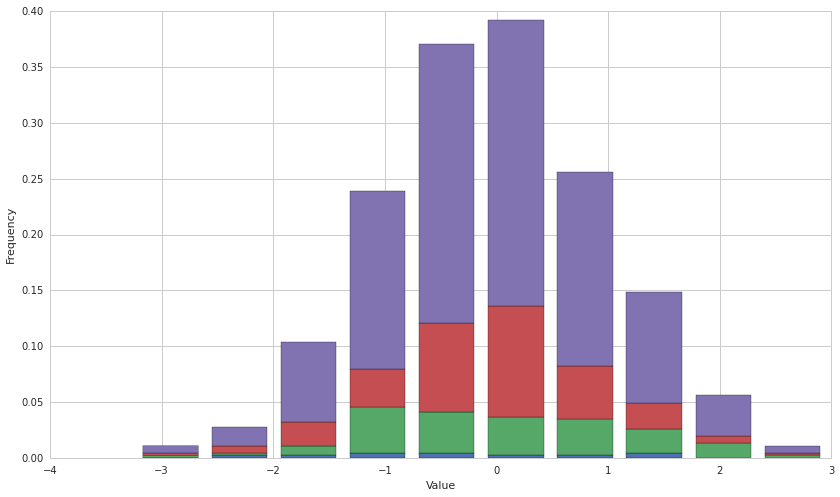

In [2]:
# Set a seed so we can play with the data without generating new random numbers every time
np.random.seed(123)

normal = np.random.randn(500)
print np.mean(normal[:10])
print np.mean(normal[:100])
print np.mean(normal[:250])
print np.mean(normal)

# Plot a stacked histogram of the data
plt.hist([normal[:10], normal[10:100], normal[100:250], normal], normed=1, histtype='bar', stacked=True);
plt.ylabel('Frequency')
plt.xlabel('Value');

In [3]:
print np.std(normal[:10])
print np.std(normal[:100])
print np.std(normal[:250])
print np.std(normal)

1.2363048015
1.12824047048
1.01746043683
1.00320285616


Notice that, although the probability of getting closer to 0 and 1 for the mean and standard deviation, respectively, increases with the number of samples, we do not always get better estimates by taking more data points. Whatever our expectation is, we can always get a different result, and our goal is often to compute the probability that the result is significantly different than expected.

With time series data, we usually care only about contiguous subsets of the data. The moving average (also called running or rolling) assigns the mean of the previous $n$ data points to each point in time. Below, we compute the 90-day moving average of a stock price and plot it to see how it changes. There is no result in the beginning because we first have to accumulate at least 90 days of data.

##Example: Non-Normal Underlying Distribution

What happens if the underlying data isn't normal? A mean will be very deceptive. Because of this it's important to test for normality of your data. We'll use a Jarque-Bera test as an example.

mean: 0.00984758128215
standard deviation: 5.06070874011


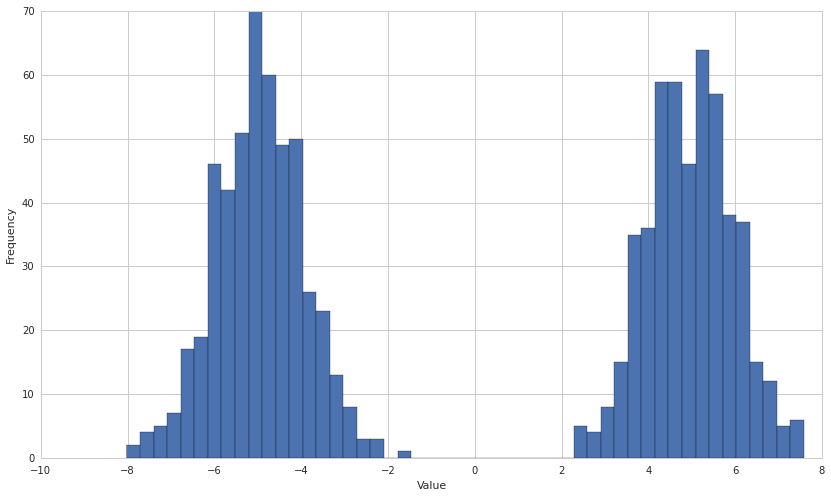

In [4]:
#Generate some data from a bi-modal distribution
def bimodal(n):
    X = np.zeros((n))
    for i in range(n):
        if np.random.binomial(1, 0.5) == 0:
            X[i] = np.random.normal(-5, 1)
        else:
            X[i] =  np.random.normal(5, 1)
    return X
            
X = bimodal(1000)

#Let's see how it looks
plt.hist(X, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Value')
print 'mean:', np.mean(X)
print 'standard deviation:', np.std(X)

Sure enough, the mean is incredibly non-informative about what is going on in the data. We have collapsed all of our data into a single estimate, and lost of a lot of information doing so. This is what the distribution should look like if our hypothesis that it is normally distributed is correct.

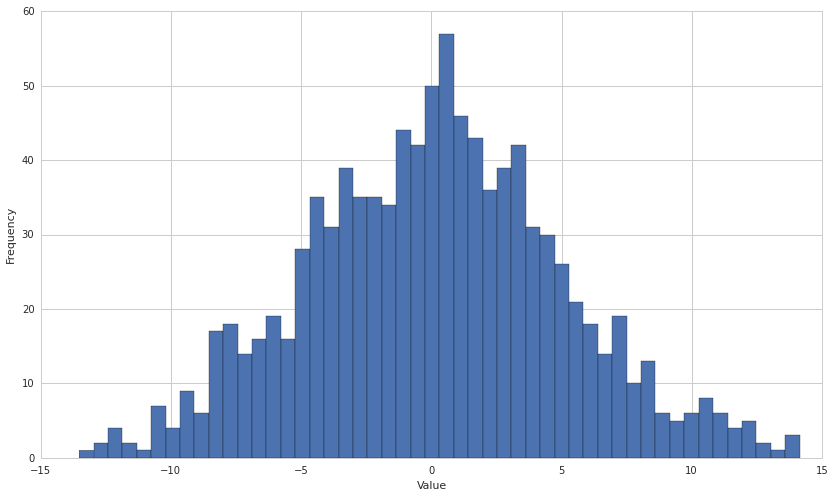

In [5]:
mu = np.mean(X)
sigma = np.std(X)

N = np.random.normal(mu, sigma, 1000)

plt.hist(N, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Value');

We'll test our data using the Jarque-Bera test to see if it's normal. A significant p-value indicates non-normality.

In [6]:
from statsmodels.stats.stattools import jarque_bera

jarque_bera(X)

(142.12550136207705,
 1.3735343038981241e-31,
 -0.007644415681800421,
 1.1531707484649847)

Sure enough the value is < 0.05 and we say that X is not normal. This saves us from accidentally making horrible predictions.

# Example: Sharpe ratio

One statistic often used to describe the performance of assets and portfolios is the Sharpe ratio, which measures the additional return per unit additional risk achieved by a portfolio, relative to a risk-free source of return such as Treasury bills:
$$R = \frac{E[r_a - r_b]}{\sqrt{Var(r_a - r_b)}}$$

where $r_a$ is the returns on our asset and $r_b$ is the risk-free rate of return. As with mean and standard deviation, we can compute a rolling Sharpe ratio to see how our estimate changes through time.

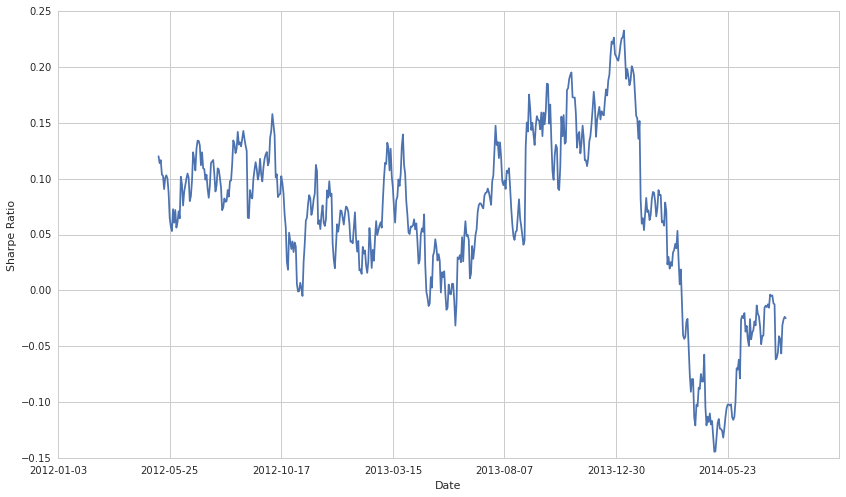

In [7]:
def sharpe_ratio(asset, riskfree):
    return np.mean(asset - riskfree)/np.std(asset - riskfree)

start = '2012-01-01'
end = '2015-01-01'
# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = get_pricing('BIL', fields='price', start_date=start, end_date=end).pct_change()[1:]
pricing = get_pricing('AMZN', fields='price', start_date=start, end_date=end)
returns = pricing.pct_change()[1:] # Get the returns on the asset

# Compute the running Sharpe ratio
running_sharpe = [sharpe_ratio(returns[i-90:i], treasury_ret[i-90:i]) for i in range(90, len(returns))]

# Plot running Sharpe ratio up to 100 days before the end of the data set
_, ax1 = plt.subplots()
ax1.plot(range(90, len(returns)-100), running_sharpe[:-100]);
ticks = ax1.get_xticks()
ax1.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio');

The Sharpe ratio looks rather volatile, and it's clear that just reporting it as a single value will not be very helpful for predicting future values. Instead, we can compute the mean and standard deviation of the data above, and then see if it helps us predict the Sharpe ratio for the next 100 days.

Mean of running Sharpe ratio: 0.0646215053325
std of running Sharpe ratio: 0.0778015776531


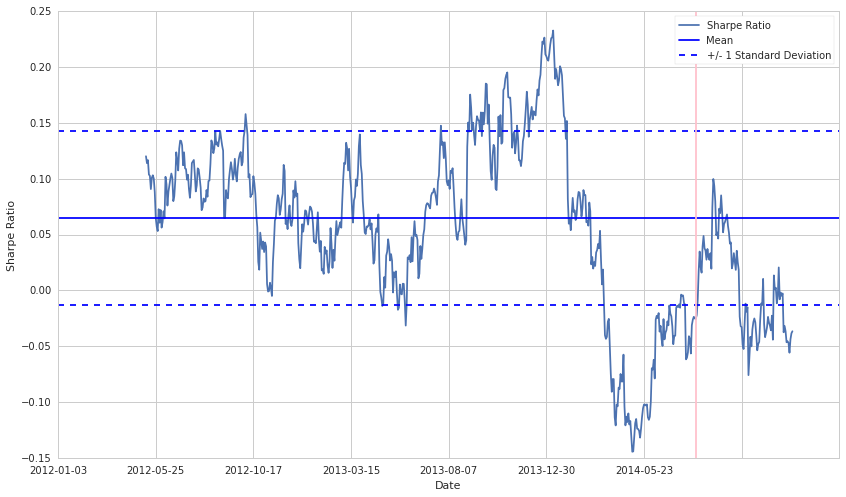

In [8]:
# Compute the mean and std of the running Sharpe ratios up to 100 days before the end
mean_rs = np.mean(running_sharpe[:-100])
std_rs = np.std(running_sharpe[:-100])

# Plot running Sharpe ratio
_, ax2 = plt.subplots()
ax2.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
ax2.plot(range(90, len(returns)), running_sharpe)

# Plot its mean and the +/- 1 standard deviation lines
ax2.axhline(mean_rs)
ax2.axhline(mean_rs + std_rs, linestyle='--')
ax2.axhline(mean_rs - std_rs, linestyle='--')

# Indicate where we computed the mean and standard deviations
# Everything after this is 'out of sample' which we are comparing with the estimated mean and std
ax2.axvline(len(returns) - 100, color='pink');
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend(['Sharpe Ratio', 'Mean', '+/- 1 Standard Deviation'])

print 'Mean of running Sharpe ratio:', mean_rs
print 'std of running Sharpe ratio:', std_rs

The standard deviation in this case is about a quarter of the range, so this data is extremely volatile. Taking this into account when looking ahead gave a better prediction than just using the mean, although we still observed data more than one standard deviation away. We could also compute the rolling mean of the Sharpe ratio to try and follow trends; but in that case, too, we should keep in mind the standard deviation.

##Example: Moving Average

Let's say you take the average with a lookback window; how would you determine the standard error on that estimate? Let's start with an example showing a 90-day moving average.

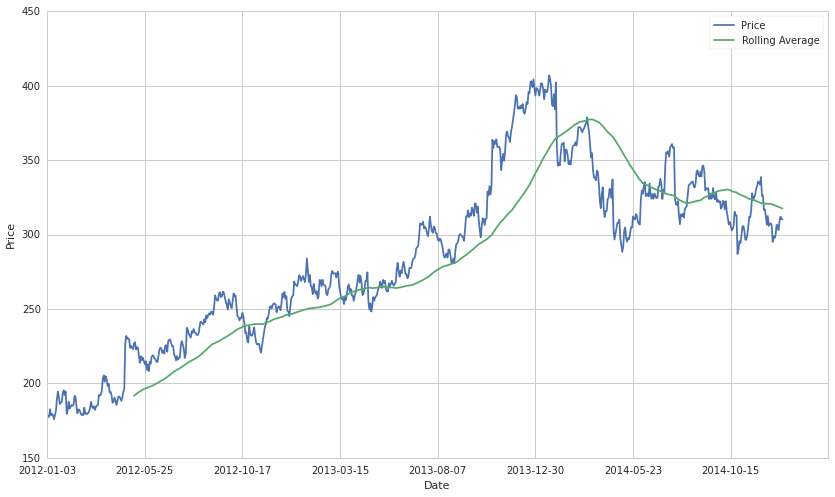

In [9]:
# Load time series of prices
start = '2012-01-01'
end = '2015-01-01'
pricing = get_pricing('AMZN', fields='price', start_date=start, end_date=end)

# Compute the rolling mean for each day
mu = pd.rolling_mean(pricing, window=90)

# Plot pricing data
_, ax1 = plt.subplots()
ax1.plot(pricing) 
ticks = ax1.get_xticks()
ax1.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
plt.ylabel('Price')
plt.xlabel('Date')

# Plot rolling mean
ax1.plot(mu);
plt.legend(['Price','Rolling Average']);

This lets us see the instability/standard error of the mean, and helps anticipate future variability in the data. We can quantify this variability by computing the mean and standard deviation of the rolling mean.

In [10]:
print 'Mean of rolling mean:', np.mean(mu)
print 'std of rolling mean:', np.std(mu)

Mean of rolling mean: 288.399003348
std of rolling mean: 51.1188097398


In fact, the standard deviation, which we use to quantify variability, is itself variable. Below we plot the rolling standard deviation (for a 90-day window), and compute <i>its</i> mean and standard deviation.

Mean of rolling std: 17.3969897999
std of rolling std: 7.54619079684


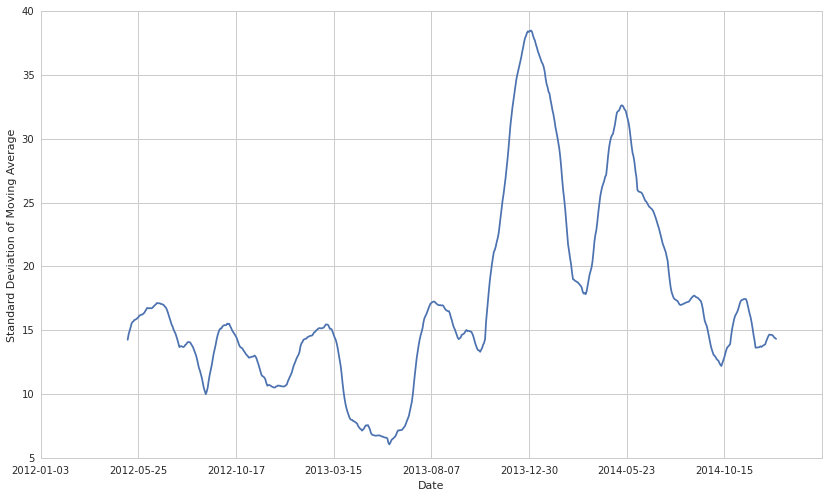

In [11]:
# Compute rolling standard deviation
std = pd.rolling_std(pricing, window=90)

# Plot rolling std
_, ax2 = plt.subplots()
ax2.plot(std)
ax2.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
plt.ylabel('Standard Deviation of Moving Average')
plt.xlabel('Date')

print 'Mean of rolling std:', np.mean(std)
print 'std of rolling std:', np.std(std)

To see what this changing standard deviation means for our data set, let's plot the data again along with the Bollinger bands: the rolling mean, one rolling standard deviation (of the data) above the mean, and one standard deviation below.

Note that although standard deviations give us more information about the spread of the data, we cannot assign precise probabilities to our expectations for future observations without assuming a particular distribution for the underlying process.

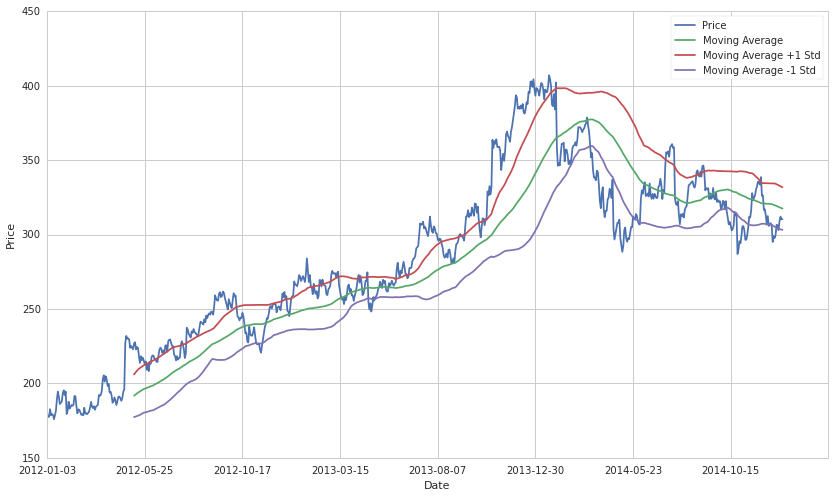

In [12]:
# Plot original data
_, ax3 = plt.subplots()
ax3.plot(pricing)
ax3.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates

# Plot Bollinger bands
ax3.plot(mu)
ax3.plot(mu + std)
ax3.plot(mu - std);
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['Price', 'Moving Average', 'Moving Average +1 Std', 'Moving Average -1 Std'])

# Conclusion

Whenever we compute a parameter for a data set, we should also compute its volatility. Otherwise, we do not know whether or not we should expect new data points to be aligned with this parameter. A good way of computing volatility is dividing the data into subsets and estimating the parameter from each one, then finding the variability among the results. There may still be outside factors which are introduced after our sample period and which we cannot predict. However, the instability analysis and testing for standard error is still very useful for telling us how much we should distrust our estimates.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*